In [41]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.display import display

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [56]:
query = """
SELECT * FROM echo_features_mx
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,mech_vent,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml
0,59654,245920,156140,70150,30260 days 15:18:03,M,66.0,263.0,42.444674,BLACK/AFRICAN AMERICAN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59659,217810,188268,82208,22331 days 14:54:57,F,59.0,136.0,27.465671,WHITE,...,1,2314.699969,17.0,2297.699969,250.000000,90.0,160.000000,NaN,NaN,NaN
2,59662,282885,100195,2489,24131 days 01:52:41,M,65.0,146.0,24.293018,UNKNOWN/NOT SPECIFIED,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59671,271833,130443,2961,30992 days 18:16:15,F,61.0,106.0,20.026337,WHITE,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59862,230661,116471,26601,-104003 days +15:46:42.290448,F,60.0,170.0,33.197222,WHITE,...,1,270.750000,363.0,-92.250000,75.583333,2890.0,-2814.416667,NaN,NaN,NaN


In [9]:
ef.columns.tolist()

['row_id',
 'icustay_id',
 'hadm_id',
 'subject_id',
 'age_at_intime',
 'gender',
 'height',
 'weight',
 'bmi',
 'ethnicity',
 'insurance',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascular',
 'ex_hypertension',
 'ex_paralysis',
 'ex_other_neurological',
 'ex_chronic_pulmonary',
 'ex_diabetes_uncomplicated',
 'ex_diabetes_complicated',
 'ex_hypothyroidism',
 'ex_renal_failure',
 'ex_liver_disease',
 'ex_peptic_ulcer',
 'ex_aids',
 'ex_lymphoma',
 'ex_metastatic_cancer',
 'ex_solid_tumor',
 'ex_rheumatoid_arthritis',
 'ex_coagulopathy',
 'ex_obesity',
 'ex_weight_loss',
 'ex_fluid_electrolyte',
 'ex_blood_loss_anemia',
 'ex_deficiency_anemias',
 'ex_alcohol_abuse',
 'ex_drug_abuse',
 'ex_psychoses',
 'ex_depression',
 'apsiii',
 'apsiii_prob',
 'apsiii_creatinine_score',
 'admittime',
 'dischtime',
 'intime',
 'outtime',
 'dod',
 'survived_icustay',
 'survived_hadm',
 'ed_chartdate',
 'ed_charttime',

(-11.0, 4331.0)
324
2512
count    10324.000000
mean       435.751840
std        709.292372
min        -11.000000
25%          0.000000
50%         79.000000
75%        561.250000
max       4331.000000
dtype: float64


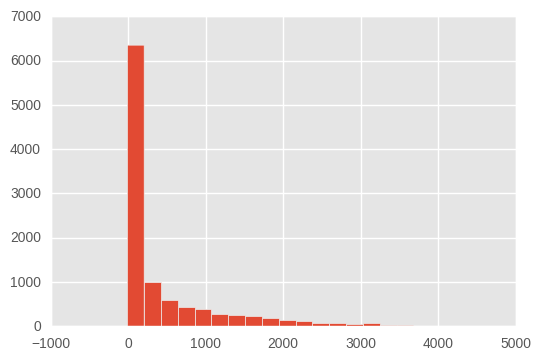

In [18]:
plot_data = ef.ea_days_after_discharge_death.values
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)
print(plot_data.min(), plot_data.max())
print(np.sum(plot_data < 0)) # only 324 out of 10k died before discharge???
print(np.sum(plot_data == 0)) # 2512 died at 0 minutes after discharge???
print(pd.Series(plot_data).describe())

In [69]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [21]:
day30_mortality.value_counts()

False    21269
True      4243
Name: ea_days_after_discharge_death, dtype: int64

In [70]:
ef['day30_mortality'] = day30_mortality

In [26]:
ef.groupby(['day30_mortality', 'mech_vent']).size().unstack()

mech_vent,0,1
day30_mortality,,
False,15666,5603
True,1911,2332


In [27]:
ef.groupby(['day30_mortality', 'noninv_vent']).size().unstack()

noninv_vent,0,1
day30_mortality,,
False,5171,16098
True,648,3595


In [30]:
%%bash
cat ../resources/lv_systolic.txt

====-1
Hyperdynamic LVEF >75%
Hyperdynamic LVEF
Left ventricular systolic function is hyperdynamic (EF>75%)
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF (>75%)
====0
Overall normal LVEF (>55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Low normal LVEF
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
There is mild symmetric left ventricular hypertrophy wi

In [71]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,94,812,9602,1747,1062,1541
True,32,340,1805,383,268,607


In [31]:
table = ef.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table /= table.sum(axis=0)
table ## severely depressed and hyperdynamic have increased likelihood of death

ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.746032,0.704861,0.841764,0.820188,0.798496,0.717412
True,0.253968,0.295139,0.158236,0.179812,0.201504,0.282588


In [33]:
table = ef.groupby(['day30_mortality', 'ex_congestive_heart_failure']).size().unstack()
table /= table.sum(axis=0)
table

ex_congestive_heart_failure,0,1
day30_mortality,,
False,0.859321,0.728075
True,0.140679,0.271925


In [44]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    #table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,74,649,8151,1453,845,1132
True,18,265,1293,244,155,356


Congestive heart failure = 1


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,20,163,1451,294,217,409
True,14,75,512,139,113,251


In [45]:
for name,group in ef.groupby('ex_congestive_heart_failure'):
    table = group.groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
    table /= table.sum(axis=0)
    print('Congestive heart failure =', name)
    display(table)

Congestive heart failure = 0


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.804348,0.710066,0.863088,0.856217,0.845,0.760753
True,0.195652,0.289934,0.136912,0.143783,0.155,0.239247


Congestive heart failure = 1


ea_lv_systolic,-50.0,-1.0,0.0,1.0,2.0,3.0
day30_mortality,,,,,,
False,0.588235,0.684874,0.739175,0.678984,0.657576,0.619697
True,0.411765,0.315126,0.260825,0.321016,0.342424,0.380303


count     18060.000000
mean       -811.258342
std        2959.623308
min     -137916.634830
25%       -1826.896563
50%        -858.625000
75%         113.000000
max       27419.000000
dtype: float64


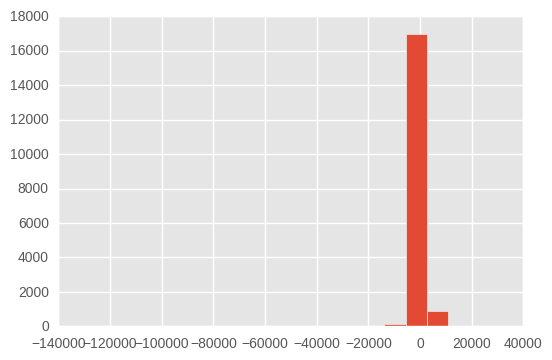

In [57]:
plot_data = ef.fl_day1_balance_ml.values
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
#someone lost 137 litres ?!?!?!?!?
#someone was given 27 litres?
_ = plt.hist(plot_data, bins=20)

count    17986.000000
mean      -718.344263
std       1940.691097
min      -6865.842370
25%      -1806.874999
50%       -851.142465
75%        117.064710
max      27419.000000
dtype: float64


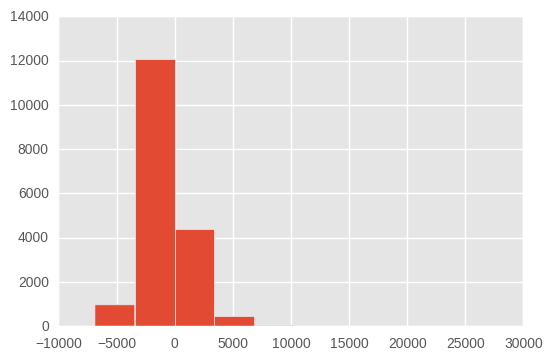

In [60]:
plot_data = ef.fl_day1_balance_ml.values.copy()
plot_data[plot_data < -7000] = np.nan
plot_data = plot_data[~np.isnan(plot_data)]
print(pd.Series(plot_data).describe())
_ = plt.hist(plot_data)

 0.0     11407
 3.0      2148
 1.0      2130
 2.0      1330
-1.0      1152
-50.0      126
Name: ea_lv_systolic, dtype: int64

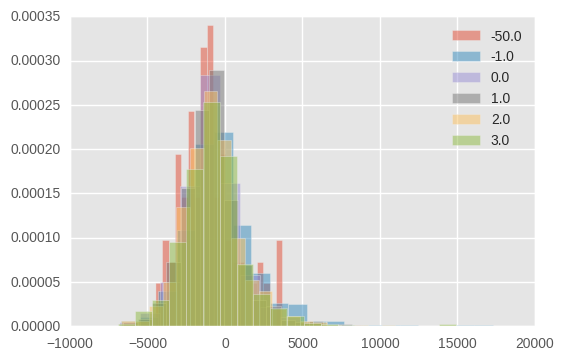

In [72]:
## if we group by echo lv systolic, what do the fluid distributions look like?
display(ef.ea_lv_systolic.value_counts())
for name,group in ef.groupby('ea_lv_systolic'):
    fluid = group.fl_day1_balance_ml.values.copy()
    fluid[fluid < -7000] = np.nan
    fluid = fluid[~np.isnan(fluid)]
    plt.hist(fluid, alpha=0.5, label=str(name), normed=True, bins=20)
plt.legend(loc='best')

In [77]:
means = ef.groupby('ea_lv_systolic').mean()
stddevs = ef.groupby('ea_lv_systolic').std()
display(means)
display(stddevs)

,row_id,icustay_id,hadm_id,subject_id,height,weight,bmi,ex_congestive_heart_failure,ex_cardiac_aarrhythmias,ex_valvular_disease,...,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,day30_mortality
ea_lv_systolic,,,,,,,,,,,,,,,,,,,,,
-50.0,81244.809524,247653.325397,149511.547619,25897.706349,66.921569,178.801887,28.027204,0.269841,0.238095,0.158730,...,1015.256498,2086.900990,-1071.644493,1106.137095,2116.014493,-1009.877397,810.632119,2298.706897,-1488.074778,0.253968
-1.0,84541.219618,250258.736979,149541.017361,42459.780382,65.783559,179.193858,28.883144,0.206597,0.219618,0.079861,...,1811.668583,2149.855422,-338.186839,1442.347326,2357.833333,-915.486007,1401.033672,2443.926874,-1042.893201,0.295139
0.0,83559.743228,250096.408433,149812.066450,41103.482160,66.431120,182.400171,29.896931,0.172087,0.200842,0.070571,...,1347.277675,2170.817390,-823.539715,1112.930153,2322.127555,-1209.197402,1060.572451,2475.068176,-1414.495725,0.158236
1.0,82597.620657,249570.284977,150528.129577,36527.725822,66.984446,182.204518,29.485365,0.203286,0.176056,0.069484,...,1218.043355,2242.224798,-1024.181443,896.495937,2224.856647,-1328.360710,806.285827,2350.451950,-1544.166123,0.179812
2.0,82000.688722,249987.902256,150698.062406,32848.561654,67.022845,177.589443,27.682084,0.248120,0.160150,0.078195,...,1326.110046,2100.788911,-774.678866,972.956970,2107.655120,-1134.698150,935.051609,2282.691701,-1347.640092,0.201504
3.0,81364.523743,249868.024674,149860.125698,32239.316574,67.278558,179.862824,27.842774,0.307263,0.188082,0.086127,...,1303.394901,2054.701618,-751.306718,982.156383,2183.628738,-1201.472354,874.978922,2395.383387,-1520.404464,0.282588


,row_id,icustay_id,hadm_id,subject_id,height,weight,bmi,ex_congestive_heart_failure,ex_cardiac_aarrhythmias,ex_valvular_disease,...,fl_day1_input_ml,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,day30_mortality
ea_lv_systolic,,,,,,,,,,,,,,,,,,,,,
-50.0,12916.887505,29679.705262,27462.778767,23907.138591,3.858092,49.298202,7.464622,0.445649,0.427618,0.366883,...,1240.462970,1235.920900,1826.524191,1338.189871,1176.466425,1681.036151,999.905413,1366.312659,1754.779124,0.437017
-1.0,12441.775771,28357.722164,29679.572008,30035.040590,4.335053,54.514580,7.956209,0.405040,0.414168,0.271196,...,2160.932192,3157.747594,3711.610135,1576.133096,3555.125474,3773.844070,1455.990717,2128.144741,2436.917964,0.456303
0.0,12692.001260,28786.804605,28949.289013,29352.285078,4.505997,60.516990,46.119473,0.377473,0.400647,0.256118,...,1539.416390,2061.241825,2389.041415,1317.949533,2482.020529,2650.216939,1330.335065,2625.845736,2784.241070,0.364978
1.0,12780.463831,28245.020612,29109.566083,28767.878606,4.903057,51.512330,35.042249,0.402538,0.380958,0.254334,...,1473.736958,4447.350679,4622.077458,1081.139534,2392.477652,2592.068539,919.248620,2656.383863,2798.191607,0.384121
2.0,12697.568366,28768.927103,28213.967735,27323.997839,4.129844,50.237319,7.463365,0.432084,0.366883,0.268580,...,1554.993529,1514.534118,2047.414619,1262.930501,1415.870771,1831.399198,1093.120817,1439.196053,1811.618966,0.401274
3.0,12957.896912,29143.845218,28751.760040,27623.891825,4.281719,56.905035,7.621860,0.461467,0.390869,0.280616,...,1837.990454,1536.149372,2200.049844,1307.801526,1644.671689,2032.290919,1051.022284,1612.753660,1922.034072,0.450363


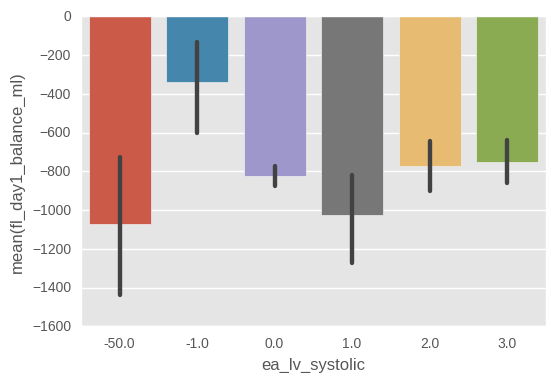

In [81]:
sns.barplot(x='ea_lv_systolic', y='fl_day1_balance_ml', data=ef)

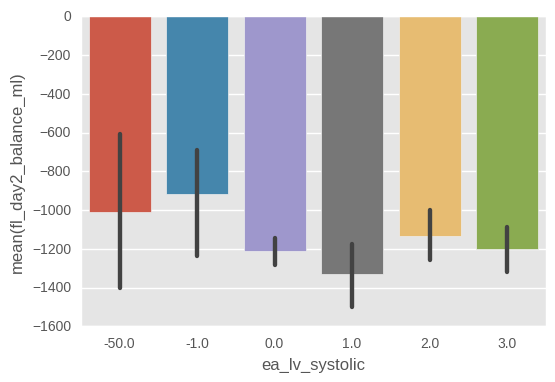

In [82]:
sns.barplot(x='ea_lv_systolic', y='fl_day2_balance_ml', data=ef)

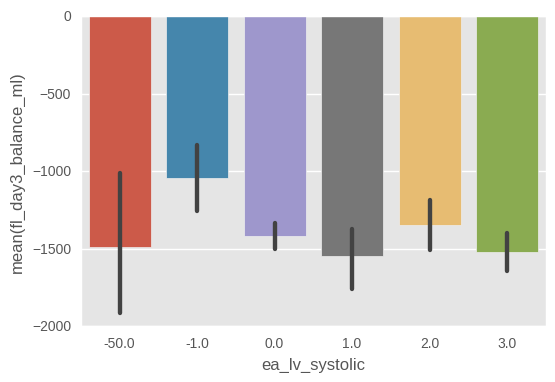

In [83]:
sns.barplot(x='ea_lv_systolic', y='fl_day3_balance_ml', data=ef)